In [115]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import itertools

In [2]:
# read data
cc_info = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/10.credit_card/cc_info.csv')
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [12]:
transactions = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/10.credit_card/transactions.csv',parse_dates = ['date'])
transactions.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [13]:
print(cc_info.info())
print('----------------------------------')
print(cc_info.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB
None
----------------------------------
        credit_card       zipcode  credit_card_limit
count  9.840000e+02    984.000000         984.000000
mean   5.410432e+15  17895.316057       12321.138211
std    2.545234e+15  23778.651105        7398.449174
min    1.003715e+15    690.000000        2000.000000
25%    3.316062e+15   3280.000000        7000.000000
50%    5.365218e+15   5820.000000       10000.000000
75%    7.562153e+15  18101.250000       16000.000000
max    9.999757e+15  98401.000000       55000.000000

In [14]:
print(transactions.info())
print('----------------------------------')
print(transactions.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   date                       294588 non-null  datetime64[ns]
 2   transaction_dollar_amount  294588 non-null  float64       
 3   Long                       294588 non-null  float64       
 4   Lat                        294588 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB
None
----------------------------------
        credit_card  transaction_dollar_amount           Long            Lat
count  2.945880e+05              294588.000000  294588.000000  294588.000000
mean   5.424562e+15                  86.008036     -76.235238      40.937669
std    2.555803e+15                 124.655954      20.135015       5.391695
min    1.003715e+15     

# Data Processing

In [15]:
data = pd.merge(left=transactions, right=cc_info, on='credit_card', how='left')
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [16]:
# extract month, weekday, and hour information
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['weekday'] = data['date'].apply(lambda x: x.dayofweek)
data['hour'] = data['date'].apply(lambda x: x.hour)

# drop useless features
data = data.drop(labels='date', axis=1)

data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


# Question 1

Your boss wants to identify those users that in your dataset never went above the monthly credit card limit (calendar month). The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [34]:
def month_transactions(df):
    month_spend = df['transaction_dollar_amount'].sum()
    credit_limit = df['credit_card_limit'].values[0]
    return pd.Series([month_spend, credit_limit], index=['total_transaction', 'credit_limit'])

In [36]:
grouped = data.groupby(['credit_card', 'month']).apply(month_transactions)
grouped = grouped.reset_index()
grouped

,credit_card,month,total_transaction,credit_limit
0,1003715054175576,7,162.56,20000.0
1,1003715054175576,8,8441.51,20000.0
2,1003715054175576,9,11281.56,20000.0
3,1003715054175576,10,8954.21,20000.0
4,1013870087888817,7,281.43,15000.0
...,...,...,...,...
3792,9986135779184360,10,11796.95,14000.0
3793,9999757432802760,7,77.59,6000.0
3794,9999757432802760,8,4408.83,6000.0
3795,9999757432802760,9,6814.72,6000.0


In [45]:
exceed = grouped.loc[grouped['credit_limit'] <  grouped['total_transaction']]
exceed_card = list(set(exceed['credit_card']))
not_exceed = [card for card in list(set(cc_info['credit_card'])) if card not in exceed_card]
print(f'Number of users never went above the monthly credit card limit: {len(not_exceed)}')

Number of users never went above the monthly credit card limit: 862


# Question 2

On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [66]:
def alert(df, month, day):
    temp = df.loc[(df['month'] == month) & (df['day'] <= day)]
    cursum = temp[['transaction_dollar_amount','credit_card']].groupby('credit_card').sum().reset_index()
    credit_limit = temp[['credit_card_limit','credit_card']].groupby('credit_card').last().reset_index()
    cursum_limit = pd.merge(left = cursum, right = credit_limit, on = 'credit_card', how ='left')
    return cursum_limit[cursum_limit['transaction_dollar_amount'] > cursum_limit['credit_card_limit']]

In [67]:
# example
alert(data, month=8, day=20)

,credit_card,transaction_dollar_amount,credit_card_limit
194,2850146878241916,4012.81,4000
319,3936887050542904,5352.07,4000
341,4118286032166087,3416.52,3000
383,4462290711836916,3119.53,2000
525,5723635641134781,2161.30,2000
698,7299183791723634,7074.49,7000
772,7850942767136368,5704.00,4000
834,8522875529951473,5860.89,5000
874,8972201384562696,5266.08,5000


# Question 3

Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

I think there are two factors which impact a transaction is fraud or not:

- if the transaction violates that user's consumption habit. For example, if a user spend less then 200 each transaction most of the time, then a transaction more than 1000 will be highly suspicious.
- if user spend the money far from his home, although it is possible due to traveling, but it's still very suspicious.

Although the data provide each transaction's geometric information and card holder's home, unfortunately, due to time limits, I cannot relate each transation's 'Long' and 'Lat' with that card holder's home address. 

if given more time, I would use some Map Web API to map Long/Lat to address, and compare with card-holder's address, which will be a very useful feature to detect credit fraud.

For factor 2, I decide to use median of lat and long as a indicator of user's spending area.

In [72]:
# in the first factor, I will use spending statistiscs (25%, 50% and 75% percentiles) 
# to describe each user's consumption habit
def statistics_by_card(s):
    ps = [25, 50, 75]
    d = np.percentile(s,ps)
    return pd.Series(d,index=['{}%'.format(p) for p in ps])

tran_statistics = transactions.groupby('credit_card')['transaction_dollar_amount'].apply(statistics_by_card).unstack().reset_index()  
tran_statistics

,credit_card,25%,50%,75%
0,1003715054175576,59.0100,93.730,124.630
1,1013870087888817,58.0900,87.670,128.020
2,1023820165155391,55.4300,85.780,122.830
3,1073931538936472,108.0800,147.190,194.830
4,1077622576192810,122.9300,148.180,160.110
...,...,...,...,...
979,9958678964376192,91.3100,145.300,201.560
980,9961694231875562,43.5500,70.750,104.100
981,9981251982982618,75.5375,132.615,186.445
982,9986135779184360,31.6250,51.320,72.060


In [84]:
long_median = transactions[['credit_card','Long']].groupby('credit_card').median().reset_index().rename(columns={'Long':'Long_median'})
lat_median = transactions[['credit_card','Lat']].groupby('credit_card').median().reset_index().rename(columns={'Lat':'Lat_median'})

In [195]:
# merge with each transaction
data_stats = pd.merge(left = data, right = tran_statistics, on = 'credit_card', how = 'left')
data_stats = pd.merge(left = data_stats, right = long_median, on = 'credit_card', how = 'left')
data_stats = pd.merge(left = data_stats, right = lat_median, on = 'credit_card', how = 'left')
data_stats.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,59.01,93.73,124.63,-80.210281,40.242914
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,59.01,93.73,124.63,-80.210281,40.242914
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,59.01,93.73,124.63,-80.210281,40.242914
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,59.01,93.73,124.63,-80.210281,40.242914
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,59.01,93.73,124.63,-80.210281,40.242914


In [196]:
# use difference of Long/Lat to Long_median/Lat_median as an indicator of 
# weather this transaction is far from the user's usual place
data_stats['Long_diff'] = abs(data_stats['Long'] - data_stats['Long_median'] )
data_stats['Lat_diff'] = abs(data_stats['Lat'] - data_stats['Lat_median'])
data_stats.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median,Long_diff,Lat_diff
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,59.01,93.73,124.63,-80.210281,40.242914,0.036149,0.024456
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,59.01,93.73,124.63,-80.210281,40.242914,0.016042,0.062801
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,59.01,93.73,124.63,-80.210281,40.242914,0.000751,0.070090
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,59.01,93.73,124.63,-80.210281,40.242914,0.036143,0.047981
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,59.01,93.73,124.63,-80.210281,40.242914,0.028438,0.076195


In [198]:
# select features for modelling
X = data_stats.loc[:,['transaction_dollar_amount','25%','50%','75%', 'credit_card_limit','Long_diff','Lat_diff']]
X.describe()

,transaction_dollar_amount,25%,50%,75%,credit_card_limit,Long_diff,Lat_diff
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716,1.908423,0.383721
std,124.655954,21.471896,35.160028,49.919646,7956.291556,16.902665,3.879683
min,0.010000,6.150000,7.320000,9.120000,2000.000000,0.000000,0.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000,0.017729,0.017732
50%,58.470000,40.595000,65.190000,91.832500,15000.000000,0.036646,0.036627
75%,100.400000,56.215000,89.710000,127.345000,20000.000000,0.057878,0.057875
max,999.970000,137.690000,222.290000,318.730000,55000.000000,336.157890,111.221499


First I would like to visualize the data in 2d, so I apply PCA.

In [199]:
X = scale(X)

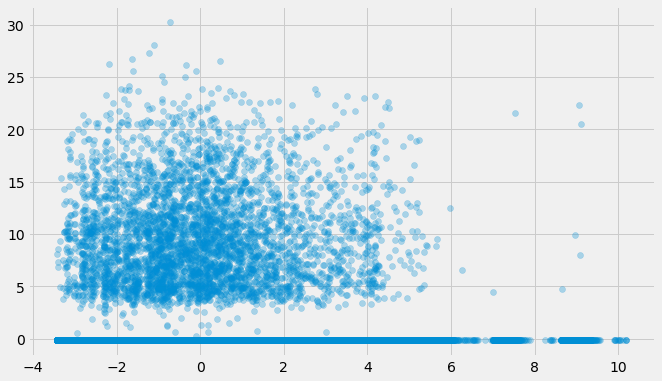

In [200]:
pca = PCA(n_components=2)
X2d = pca.fit_transform(X)
X2d = pd.DataFrame(X2d,columns=['pc1','pc2'])

plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3)

The above plot shows there are two separated groups in the data. So next I apply K-means to cluster the the data

In [185]:
X2d['label'] = 0
X2d.loc[(X2d['pc1']>9),'label'] = 1

In [169]:
suspect = data_stats.loc[X2d.label==1]
suspect

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median,Long_diff,Lat_diff
154374,5644143320838397,247.80,121.941257,-35.834159,Denver,NY,12421,55000,8,22,5,20,137.69,219.66,317.58,-74.545666,42.247146,196.486923,-78.081305
154375,5644143320838397,206.63,-74.525911,42.201094,Denver,NY,12421,55000,10,2,4,16,137.69,219.66,317.58,-74.545666,42.247146,0.019755,-0.046052
154376,5644143320838397,184.75,-74.609851,42.227784,Denver,NY,12421,55000,10,1,3,23,137.69,219.66,317.58,-74.545666,42.247146,-0.064185,-0.019361
154377,5644143320838397,172.99,-74.512915,42.181818,Denver,NY,12421,55000,8,24,0,20,137.69,219.66,317.58,-74.545666,42.247146,0.032750,-0.065328
154378,5644143320838397,312.16,-74.563564,42.182599,Denver,NY,12421,55000,10,6,1,20,137.69,219.66,317.58,-74.545666,42.247146,-0.017898,-0.064546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197681,6945217470076371,75.40,-94.565062,39.147253,Kansas City,MO,64101,28000,8,17,0,23,123.59,222.29,318.73,-94.603661,39.103775,0.038598,0.043478
197682,6945217470076371,286.38,-94.535313,39.088461,Kansas City,MO,64101,28000,10,27,1,20,123.59,222.29,318.73,-94.603661,39.103775,0.068348,-0.015314
197683,6945217470076371,498.92,-94.553827,39.134458,Kansas City,MO,64101,28000,10,15,3,21,123.59,222.29,318.73,-94.603661,39.103775,0.049834,0.030683
197684,6945217470076371,133.12,-94.612085,39.089824,Kansas City,MO,64101,28000,10,28,2,23,123.59,222.29,318.73,-94.603661,39.103775,-0.008424,-0.013950


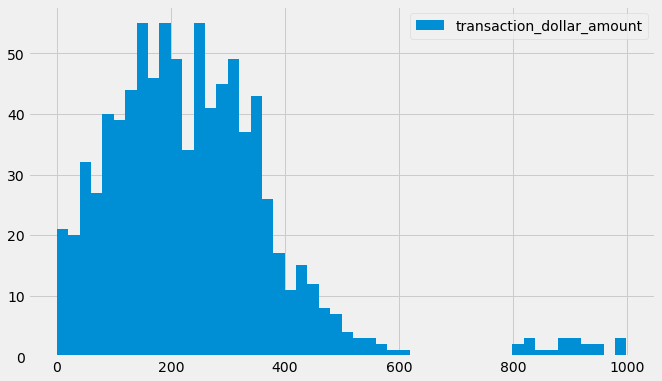

In [170]:
labels = ["transaction_dollar_amount"]
plt.hist(suspect.loc[:,labels].values,bins=50,label=labels)
plt.legend(loc='best')

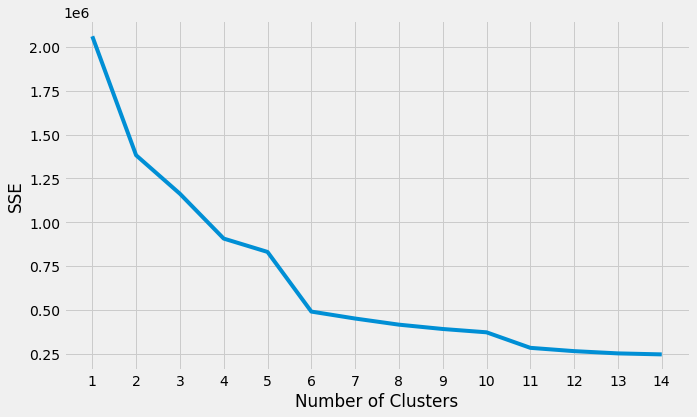

In [201]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}
# A list holds the SSE values for each k
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [202]:
# choose k = 6
n_cluster = 6
kmeans = KMeans(init="random",n_clusters=n_cluster,n_init=10,max_iter=300,random_state=42)
kmeans.fit(X)

KMeans(init='random', n_clusters=6, random_state=42)

In [203]:
# check class labels count
class_label = kmeans.labels_
class_values, class_counts = np.unique(class_label, return_counts=True)
for i in range(len(class_values)):
    print('class:',class_values[i],'count:',class_counts[i])

class: 0 count: 114313
class: 1 count: 23620
class: 2 count: 3393
class: 3 count: 5378
class: 4 count: 75501
class: 5 count: 72383


In [204]:
X2d['label'] = kmeans.labels_

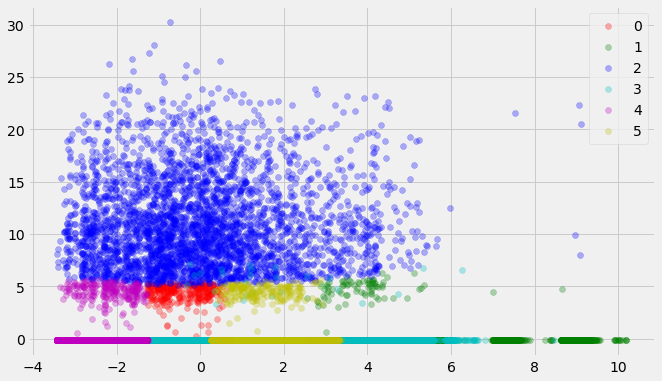

In [205]:
colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

plt.rc('figure',figsize=(10,6))
for label in range(n_cluster) :
    temp = X2d.loc[X2d.label == label,:]
    plt.scatter(temp.pc1,temp.pc2,c=next(colors),label=label,alpha=0.3)

plt.legend(loc='best')

In [206]:
suspicious_label = 2
suspect = data_stats.loc[X2d.label==suspicious_label]
suspect

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median,Long_diff,Lat_diff
14,1003715054175576,146.75,69.475216,25.125749,Houston,PA,15342,20000,9,18,4,21,59.0100,93.730,124.630,-80.210281,40.242914,149.685497,15.117165
113,1003715054175576,99.27,34.429275,24.659874,Houston,PA,15342,20000,9,8,1,16,59.0100,93.730,124.630,-80.210281,40.242914,114.639557,15.583040
128,1003715054175576,87.77,102.032338,-32.343578,Houston,PA,15342,20000,10,25,6,0,59.0100,93.730,124.630,-80.210281,40.242914,182.242619,72.586492
141,1003715054175576,53.31,-7.373733,-11.785999,Houston,PA,15342,20000,9,25,4,20,59.0100,93.730,124.630,-80.210281,40.242914,72.836548,52.028913
306,1013870087888817,40.52,110.386103,52.238635,Washington,NH,3280,15000,10,6,1,0,58.0900,87.670,128.020,-72.093306,43.170356,182.479409,9.068279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293735,9981251982982618,83.15,107.024289,5.903593,New York,NY,10001,18000,8,20,3,17,75.5375,132.615,186.445,-73.999314,40.751616,181.023602,34.848024
293776,9981251982982618,82.09,3.183700,55.997719,New York,NY,10001,18000,10,10,5,22,75.5375,132.615,186.445,-73.999314,40.751616,77.183014,15.246102
293900,9981251982982618,116.08,123.446448,-0.895321,New York,NY,10001,18000,10,20,1,20,75.5375,132.615,186.445,-73.999314,40.751616,197.445762,41.646938
294360,9986135779184360,21.65,34.990643,47.021740,Houston,PA,15342,14000,9,2,2,22,31.6250,51.320,72.060,-80.215688,40.238941,115.206331,6.782799


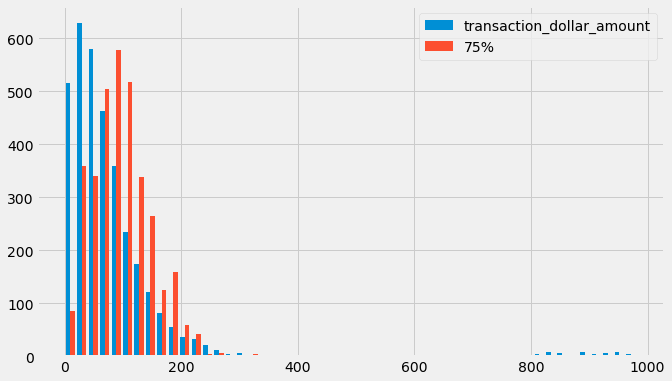

In [207]:
labels = ["transaction_dollar_amount","75%"]
plt.hist(suspect.loc[:,labels].values,bins=50,label=labels)
plt.legend(loc='best')